# **📈 Predicting StockX Sneaker Prices using SageMaker DeepAR**
---

## **Contents**

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)

---

## **Background**
This notebook demonstrates time series forecasting using the Amazon SageMaker DeepAR alogrithm by analyzing Stockx sneaker prices.  


<span style="color:red; font-weight: bold">Disclaimer</span> : Please note that I am a newbie to AI/ML. I built this project so I can further my own learning in Machine Learning. I am sharing it because I hope it can assist someone who is also on a similar journey as I am. 

---

## **Setup** 
This notebook was created and tested on a ml.m4.xlarge instance. 



### Enable Kaggle Tools 

What is Kaggle? Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges. You can find out more about Kaggle on their [website](https://www.kaggle.com/). 

We will be using Kaggle to download the Stockx sneaker sales dataset.

In [44]:
!pip install --q kaggle 


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


To use Kaggle API, you must have an account and an API token. You can register for a Kaggle account [here](https://www.kaggle.com/docs/api) and generate your API token, it is completely free. 

In [45]:
!touch ~/.kaggle/kaggle.json # Creates json file to store Kaggle API Credentials
kaggle_api_token = {"username":"gilbertyoungjr","key":"9c1e0b76bd43718e8bf816ac26e05824"}  # Insert your own username and API Key here

In [46]:
import json 

# Writes API Credentials to Kaggle file
with open('/root/.kaggle/kaggle.json', 'w') as file: 
    json.dump(kaggle_api_token,file)
    

For security reasons, we must ensure that other users of our computer do not have read access to our Kaggle credentials.

In [47]:
!chmod 600 ~/.kaggle/kaggle.json

### Import Packages

In [76]:
import sagemaker
import boto3
import io
import json
import time
from datetime import timedelta
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd

import s3fs


Let's start by specifying:

1. The S3 Bucket that will be used for training and model data
1. IAM arn used to give training and hosting access to the data See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace sagemaker.get_execution_role() with the appropriate full IAM role arn string(s).

In [97]:
sagemaker_session = sagemaker.Session() # Use to interact with SageMaker services
s3_bucket = sagemaker_session.default_bucket() # Return the name of the default bucket to use for SageMaker interactions.
s3_prefix = "stockx_sneaker_prices"  # Change to your desired S3 prefix
region = sagemaker_session.boto_region_name # Sets default region for SageMaker

# Defines data path to store files 
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)
role = sagemaker.get_execution_role() # Return IAM Role used by SageMaker 


Next, we configure the container image to be used for the region that we are running in.

In [50]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region) # Defines which alogrithm to use

---
## **Data** 
The dataset used in this project, is from the [StockX 2019 Data Contest](https://www.kaggle.com/datasets/hudsonstuck/stockx-data-contest).

The data consists of a random sample of all Off-White x Nike and Yeezy 350 sales from between 9/1/2017 (the month that Off-White first debuted “The Ten” collection) and the present. There are 99,956 total sales in the data set; 27,794 Off-White sales, and 72,162 Yeezy sales. The sample consists of U.S. sales only.

In [51]:
#!kaggle datasets list # List available datasets
!kaggle datasets download -d hudsonstuck/stockx-data-contest --unzip # Downloads & Unzip dataset

  0%|                                                | 0.00/711k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 711k/711k [00:00<00:00, 7.58MB/s]


Now that the dataset is downloaded, let us visualize what the data looks like. 

In [52]:
initial_data = pd.read_csv('StockX-Data-Contest-2019-3.csv', header = 0, parse_dates=['Order Date', 'Release Date'])
df = initial_data.copy()
df.head() # Display first 5 rows

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2017-02-11,11.0,Rhode Island


### Data Cleaning 
The data is already somewhat nicely formatted for us, but there are still a few cleaning we have to do. 

1. Remove dashes ('-') from Sneaker Name 
1. Remove dollar sign ('$') and comma (',') from prices (Sales Price, Retail Price)
1. Convert Sale Price and Retail Price to type float64

In [37]:
# Remove dashes ('-') from Sneaker Name 
df['Sneaker Name'] = df['Sneaker Name'].apply(lambda x: x.replace('-', ' '))

In [53]:
# Remove dollar sign ('$') and comma (',') from prices (Sales Price, Retail Price) 
# Converts values to type float64
df['Sale Price'] = df['Sale Price'].apply(lambda x: x.replace('$', ''))
df['Sale Price'] = df['Sale Price'].apply(lambda x: x.replace(',', ''))
df['Sale Price'] = df['Sale Price'].astype(float)
df['Retail Price'] = df['Retail Price'].apply(lambda x: x.replace('$', ''))
df['Retail Price'] = df['Retail Price'].apply(lambda x: x.replace(',', ''))
df['Retail Price'] = df['Retail Price'].astype(float)

In [54]:
# Renaming columns to remove spaces 
df = df.rename(columns={
    "Order Date": "order_date",
    "Brand": "brand",
    "Sneaker Name": "sneaker_name",
    "Sale Price": "sale_price",
    "Retail Price": "retail_price",
    "Release Date": "release_date",
    "Shoe Size": "shoe_size",
    "Buyer Region": "buyer_region"
    })

In [56]:
# Convert Categorical Values to numeric
clean_data = pd.get_dummies(df, columns=['sneaker_name'])
#clean_data.head()

### Visualization of Data
Now that the data is perfeclty formatted, we can illustrate the insights below. 

1. Average Daily Sales 

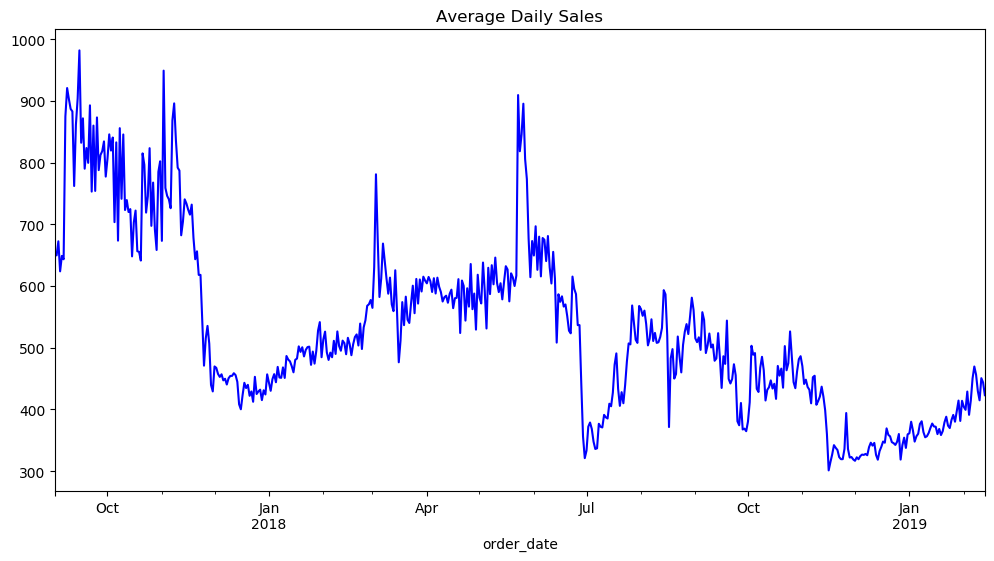

In [57]:
daily_sales = df.resample('D', on='order_date')['sale_price'].mean()

plt.figure(figsize=(12,6))
daily_sales.plot(title='Average Daily Sales', color='blue')
plt.show()

### Train & Test Splits

Before we can run the DeepAR algorithm, we need to do one final prepartion, split data by time series for training and test and lastly
converting the data frames to JSON format. DeepAR expects input training data to be JSON fields.
You can see more on their [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html)

We specify what section of the data is used for model training: the model sees data from 2017-09-01 to 2018-05-01.

In [87]:
# Using daily frequency
freq = "D"

# we predict for 7 days
prediction_length = 7 * 12

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 12

start_dataset = pd.Timestamp("2017-09-01 00:00:00", freq)
end_training = pd.Timestamp("2018-05-01 00:00:00", freq)

#clean_data.set_index('order_date', inplace=True)

training_data = [{"start": str(start_dataset), "target": clean_data[start_dataset : end_training - timedelta(days=1)].sale_price.values.tolist()}]
test_data = [{"start": str(start_dataset), "target": clean_data[start_dataset : end_training + timedelta(days=1 * prediction_length)].sale_price.values.tolist()}]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  # This is added back by InteractiveShellApp.init_path()


Now lets write the dictionary to JSON files so DeepAR can comprehend the dataset.

In [88]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [89]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 17.1 ms, sys: 157 µs, total: 17.2 ms
Wall time: 75 ms


Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. 
Depending on your network connection, this may take a couple of minutes.

In [91]:
s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [99]:
%%time

copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://sagemaker-us-east-1-155047035098/stockx_sneaker_prices/data/train/train.json
Uploading file to s3://sagemaker-us-east-1-155047035098/stockx_sneaker_prices/data/test/test.json
CPU times: user 30.8 ms, sys: 0 ns, total: 30.8 ms
Wall time: 180 ms


Let’s have a look to what we just wrote to S3.

In [100]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[0][:100] + "...")

{"start": "2017-09-01 00:00:00", "target": [1097.0, 685.0, 690.0, 1075.0, 828.0, 798.0, 784.0, 460.0...


---
## **Train**

Now that we are completed with data cleaning and processing, we can get to the fun part to train the model and predict results.

In [103]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type="ml.c4.2xlarge",
    base_job_name="stockx_sneaker_prices",
    output_path=s3_output_path,
)

print(estimator)